In [2]:
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 16})

from sklearn.preprocessing import PolynomialFeatures

sys.path.insert(1, "../src")
from Loess import *

In [3]:
df = pd.read_csv("datasets/dataset.csv")

# Data
X = df[["radiation", "temperature", "wind"]].to_numpy()
# Target variable
y = df["ozone"].to_numpy()

# Experiments (section 5 paper)

---
## Normal probability plot

In [3]:
loess = Loess(X, y)

f = 0.4

y_hat = np.array([loess.estimate(x, kernel="tricubic", window=int(len(X)*f), degree=1) for x in X])

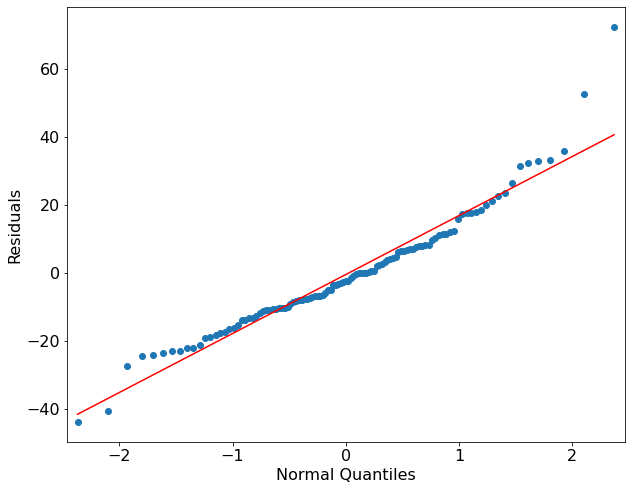

In [4]:
import seaborn as sns
import statsmodels.graphics.gofplots as sm

residuals = y - y_hat

import matplotlib as mpl

with mpl.rc_context():
    mpl.rc("figure", figsize=(10,8))
    
    sm.ProbPlot(residuals).qqplot(line="s", xlabel="Normal Quantiles", ylabel="Residuals")
    plt.savefig("img/qqplot_residuals.png")

In [5]:
f = 2/3

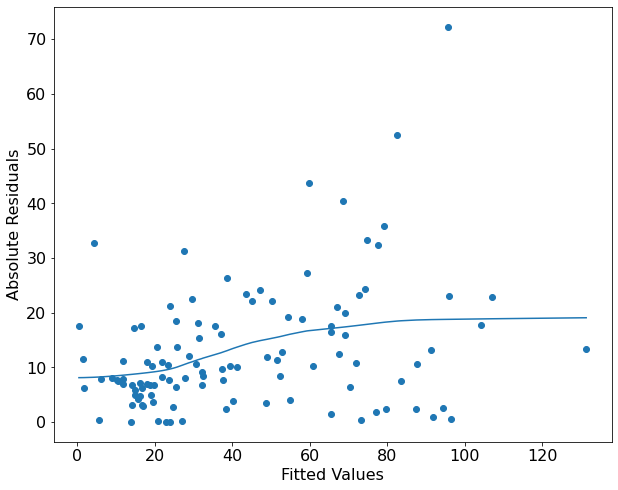

In [6]:
loess = Loess(y_hat, np.abs(residuals))

reg_residuals = np.array([loess.estimate(x, kernel="tricubic", window=int(len(X)*f), degree=1) for x in y_hat.reshape((111,1))])

reg_residuals = reg_residuals[np.argsort(y_hat)]

y_hat_a = np.sort(y_hat)

# residuals = residuals[np.argsort(y_hat)]

fig = plt.figure(figsize=(10,8))
plt.scatter(y_hat, np.abs(residuals))
plt.plot(y_hat_a, reg_residuals)
plt.xlabel("Fitted Values")
plt.ylabel("Absolute Residuals")
plt.savefig("img/fitted_abs_res.png")

In [7]:
def var_vs_residual(variable):
    data = df[variable].to_numpy()

    loess = Loess(data, residuals)

    reg_residuals = np.array([loess.estimate(x, kernel="tricubic", window=int(len(data)*f), degree=1) for x in data.reshape((111,1))])

    reg_residuals = reg_residuals[np.argsort(data)]

    y_hat = np.sort(data)
    
    fig = plt.figure(figsize=(10,8))
    plt.scatter(data, residuals)
    plt.plot(y_hat, reg_residuals)
    plt.xlabel(variable)
    plt.ylabel("Residuals")
    plt.savefig(f"img/{variable}_vs_residual.png")

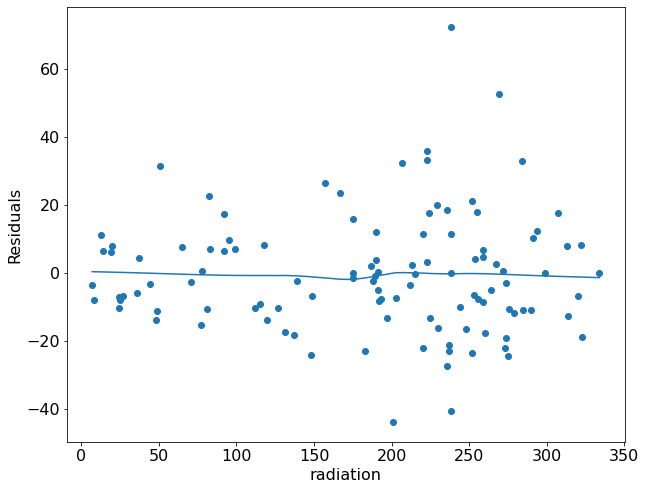

In [8]:
var_vs_residual("radiation")

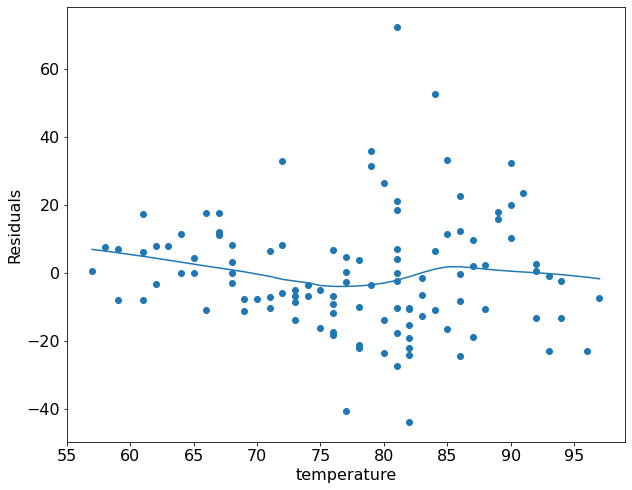

In [9]:
var_vs_residual("temperature")

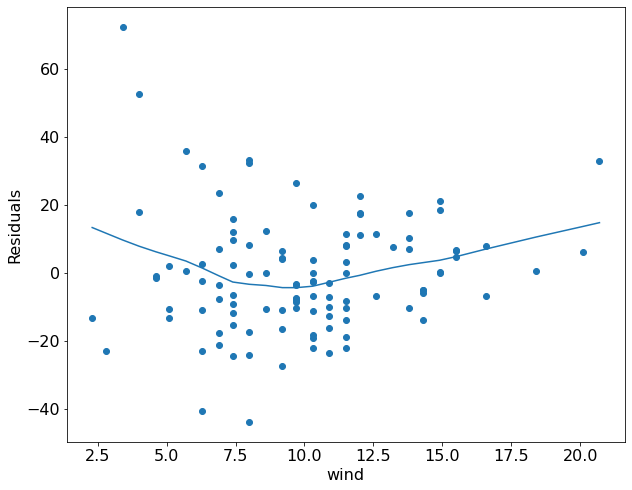

In [10]:
var_vs_residual("wind")

## Figures Page 601

In [11]:
radiations = [50, 170, 290]
winds = [5, 10, 15]
temperatures = [62, 76, 90]

max_vals = X.max(axis=0)
min_vals = X.min(axis=0)

var_radiations = X[:, 0]
# var_temperatures = np.arange(min_vals[1], max_vals[1]) # Restamos 7 ya que la regresion no tomaba suficientes valores y arrojaba valores negativos
var_temperatures = X[:, 1]
var_winds = X[:, 2]

In [12]:
fig_6_data = np.array([[[r, t, w] for t in var_temperatures] for r in radiations for w in winds])

fig_7_data = np.array([[[r, t, w] for r in var_radiations] for t in temperatures for w in winds])

fig_8_data = np.array([[[r, t, w] for w in var_winds] for r in radiations for t in temperatures])

idx_array = [6,7,8,3,4,5,0,1,2]

In [51]:
X = df[["radiation", "temperature", "wind"]].to_numpy()
# Target variable
y = df["ozone"].to_numpy()

def normalize_data(data):
        mean = np.mean(data, axis=0)
        standard_deviation = np.std(data, axis=0)
        return data / standard_deviation, mean, standard_deviation

n_xx, mean_xx, std_xx = normalize_data(X)
n_yy, mean_yy, std_yy = normalize_data(y)

loess = Loess(n_xx, n_yy)

f = 0.8

In [14]:
def plot_fig_6_8(data_list, pos):
    pred = np.array([[loess.estimate(x / std_xx, "tricubic", window=int(len(data)*f), degree=2) for x in data] for data in data_list])
    
    fig = plt.figure(figsize=(8, 8))
    axes = [plt.subplot2grid((3, 3), (i, j)) for i in range(3) for j in range(3)]
    
    inputX = data_list[0][:, pos]
    
    for i in range(len(data_list)):
        axes[idx_array[i]].plot(np.sort(inputX), np.cbrt(pred[i][np.argsort(inputX)] * std_yy))
        axes[idx_array[i]].set_ylim([0, 7])
        if pos == 2:
            axes[idx_array[i]].set_xticks([4, 8, 12, 16],[4, 8, 12, 16])
        if i in [3,4,5,6,7,8]:
            axes[idx_array[i]].set_xticks([],[])
        if i not in [0,3,6]:
            # Solo ponemos los y ticks en los subgraphs de la izquierda
            axes[idx_array[i]].set_yticks([],[])
        else:
            axes[idx_array[i]].set_yticks([1,4,7],[1,4,7])
    
    
    return plt

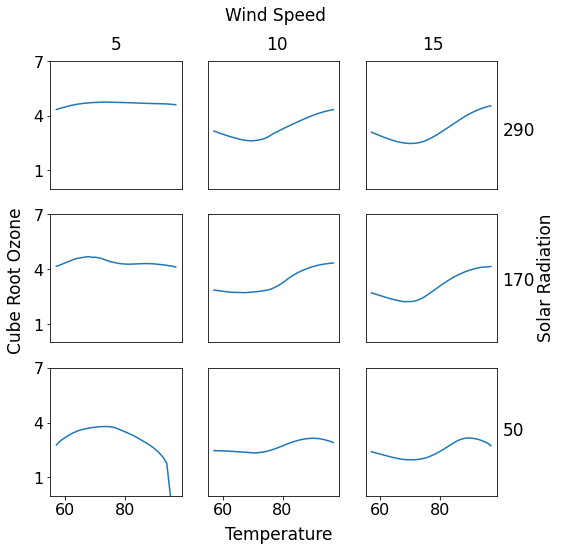

In [15]:
plot = plot_fig_6_8(fig_6_data, 1)

plot.text(0.05, 0.38, "Cube Root Ozone", fontsize=17, rotation=90, transform=plt.gcf().transFigure)
plot.text(0.428, 0.95, "Wind Speed", fontsize=17, transform=plt.gcf().transFigure)
plot.text(0.23, 0.9, "5", fontsize=17, transform=plt.gcf().transFigure)
plot.text(0.5, 0.9, "10", fontsize=17, transform=plt.gcf().transFigure)
plot.text(0.77, 0.9, "15", fontsize=17, transform=plt.gcf().transFigure)
plot.text(0.97, 0.40, "Solar Radiation", fontsize=17, rotation=90, transform=plt.gcf().transFigure)
plt.text(0.91, 0.23, "50", fontsize=17, transform=plt.gcf().transFigure)
plt.text(0.91, 0.49, "170", fontsize=17, transform=plt.gcf().transFigure)
plt.text(0.91, 0.75, "290", fontsize=17, transform=plt.gcf().transFigure)
plot.text(0.428, 0.05, "Temperature", fontsize=17, transform=plt.gcf().transFigure)
plot.savefig("img/fig_8.png")

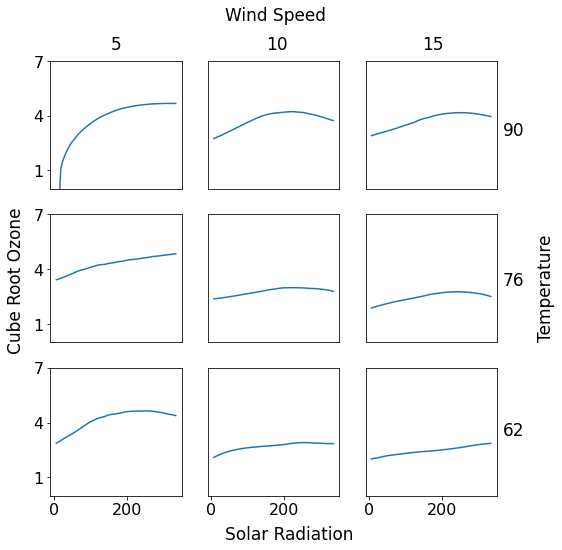

In [16]:
plot = plot_fig_6_8(fig_7_data, 0)

plot.text(0.05, 0.38, "Cube Root Ozone", fontsize=17, rotation=90, transform=plt.gcf().transFigure)
plot.text(0.428, 0.95, "Wind Speed", fontsize=17, transform=plt.gcf().transFigure)
plot.text(0.23, 0.9, "5", fontsize=17, transform=plt.gcf().transFigure)
plot.text(0.5, 0.9, "10", fontsize=17, transform=plt.gcf().transFigure)
plot.text(0.77, 0.9, "15", fontsize=17, transform=plt.gcf().transFigure)
plot.text(0.97, 0.40, "Temperature", fontsize=17, rotation=90, transform=plt.gcf().transFigure)
plt.text(0.91, 0.23, "62", fontsize=17, transform=plt.gcf().transFigure)
plt.text(0.91, 0.49, "76", fontsize=17, transform=plt.gcf().transFigure)
plt.text(0.91, 0.75, "90", fontsize=17, transform=plt.gcf().transFigure)
plot.text(0.428, 0.05, "Solar Radiation", fontsize=17, transform=plt.gcf().transFigure)
plot.savefig("img/fig_7.png")

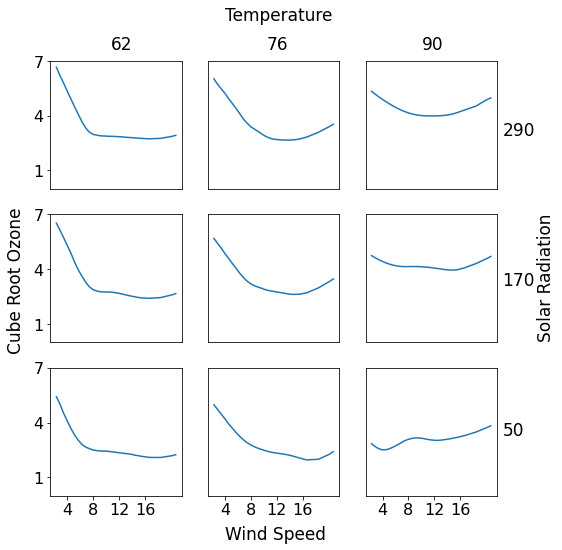

In [17]:
plot = plot_fig_6_8(fig_8_data, 2)

plot.text(0.05, 0.38, "Cube Root Ozone", fontsize=17, rotation=90, transform=plt.gcf().transFigure)
plot.text(0.428, 0.95, "Temperature", fontsize=17, transform=plt.gcf().transFigure)
plot.text(0.23, 0.9, "62", fontsize=17, transform=plt.gcf().transFigure)
plot.text(0.5, 0.9, "76", fontsize=17, transform=plt.gcf().transFigure)
plot.text(0.77, 0.9, "90", fontsize=17, transform=plt.gcf().transFigure)
plot.text(0.97, 0.40, "Solar Radiation", fontsize=17, rotation=90, transform=plt.gcf().transFigure)
plt.text(0.91, 0.23, "50", fontsize=17, transform=plt.gcf().transFigure)
plt.text(0.91, 0.49, "170", fontsize=17, transform=plt.gcf().transFigure)
plt.text(0.91, 0.75, "290", fontsize=17, transform=plt.gcf().transFigure)
plot.text(0.428, 0.05, "Wind Speed", fontsize=17, transform=plt.gcf().transFigure)
plot.savefig("img/fig_6.png")

---
# Probando con la seno

In [3]:
X = np.linspace(0, 2, num=100)
y_s = np.sin(X * np.pi) + np.cos(X * np.pi) + (np.random.normal(0, 0.15, size=len(X)))

y_o = np.sin(X * np.pi) + np.cos(X * np.pi)

l = Loess(X, y_s)

In [4]:
degrees = [1, 2]
n = X.shape[0]
q = list(range(5, n, 25))
f = [q_i / n for q_i in q]
dist_funcs = ["bisquare", "tricubic"]

In [5]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

1-bisquare
1-tricubic
2-bisquare
2-tricubic


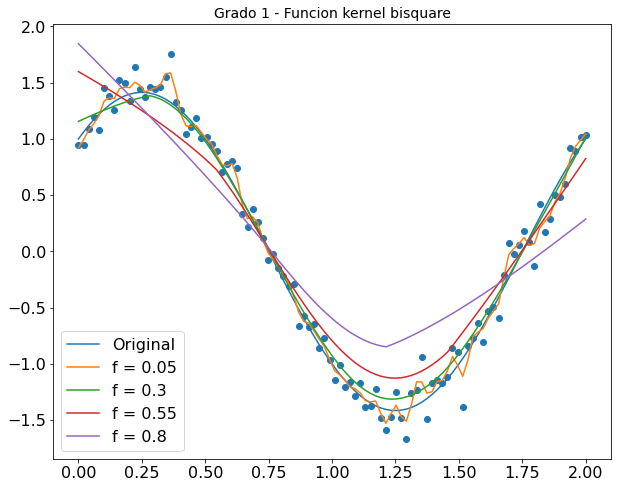

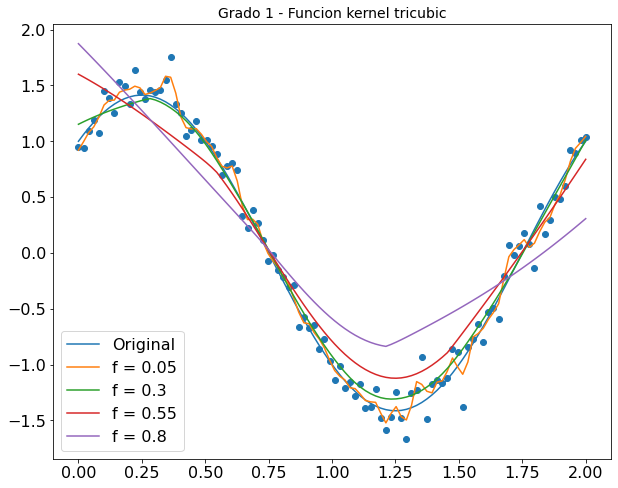

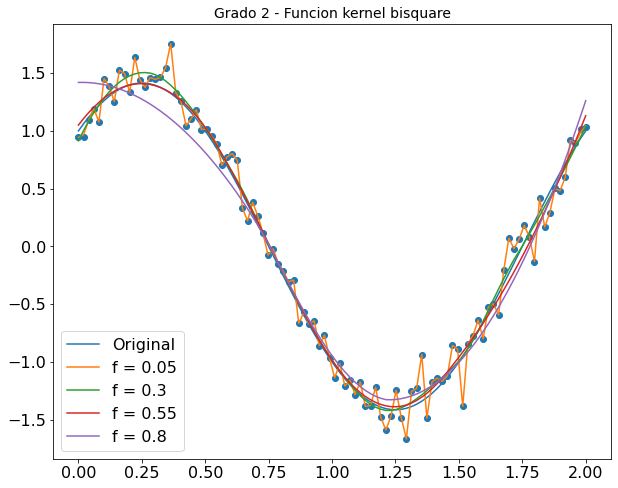

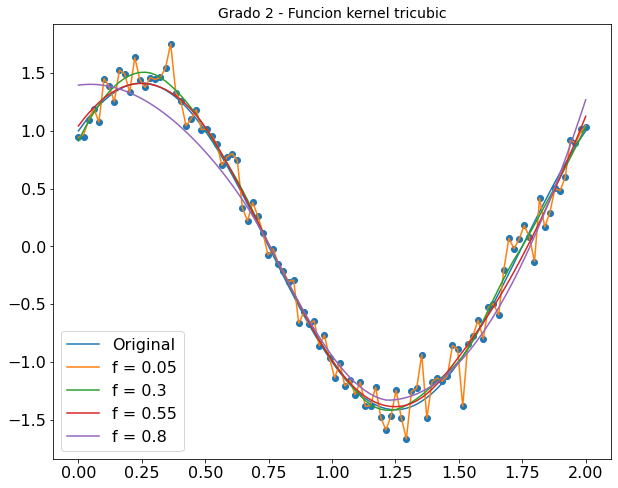

In [38]:
metrics = {}

for d in degrees:
    for func in dist_funcs:
        print(f"{d}-{func}")
        fig = plt.figure(figsize=(10,8))
        plt.scatter(X, y_s)
        plt.plot(X, y_o, label="Original")
        for frac in f:
            y_t = np.array([l.estimate(x, kernel=func, window=int(n*frac), degree=d) for x in X.reshape((100,1))])
            metrics[f"{d}-{func}-{frac}"] = {
                "MAE": mean_absolute_error(y_o, y_t)
            }
            plt.plot(X, y_t, label=f"f = {frac}")
        
        plt.title(f"Grado {d} - Funcion kernel {func}", fontsize=14)
        plt.legend()
        # plt.savefig(f"img/exp2_{d}_{func}")

In [22]:
metrics

{'1-bisquare-0.05': {'MAE': 0.057272271598781774},
 '1-bisquare-0.3': {'MAE': 0.07001191986779914},
 '1-bisquare-0.55': {'MAE': 0.19034474395360768},
 '1-bisquare-0.8': {'MAE': 0.358441716616423},
 '1-tricubic-0.05': {'MAE': 0.056364109314896764},
 '1-tricubic-0.3': {'MAE': 0.07045644710107685},
 '1-tricubic-0.55': {'MAE': 0.1931245712975706},
 '1-tricubic-0.8': {'MAE': 0.3672446943698584},
 '2-bisquare-0.05': {'MAE': 0.10469710199291653},
 '2-bisquare-0.3': {'MAE': 0.03466595702672176},
 '2-bisquare-0.55': {'MAE': 0.03952819885502122},
 '2-bisquare-0.8': {'MAE': 0.11453904803000761},
 '2-tricubic-0.05': {'MAE': 0.1044692921250374},
 '2-tricubic-0.3': {'MAE': 0.03488847205620895},
 '2-tricubic-0.55': {'MAE': 0.038605299338864744},
 '2-tricubic-0.8': {'MAE': 0.11246072278364522}}

In [16]:
0.07841606625398968
0.062010934037224255
0.1830445460640519
0.3533170956968298
0.07654357754957349
0.06264101652875231
0.1856948275109241
0.3618385235953066
0.1307143856976512
0.04257014236128512
0.05282681805824375
0.12024935902629796
0.1308600092441211
0.04267432521388925
0.05203758073026545
0.11844113627046023

0.11844113627046023

## Otros escenarios

In [12]:
X = np.linspace(-2, 2, num=100)
y_s = np.square(X) + (np.random.normal(0, 0.15, size=len(X)))

y_o = np.square(X)

degrees = [1, 2]
n = X.shape[0]
q = list(range(5, n, 25))
f = [q_i / n for q_i in q]
dist_funcs = ["bisquare", "tricubic"]

l = Loess(X, y_s)

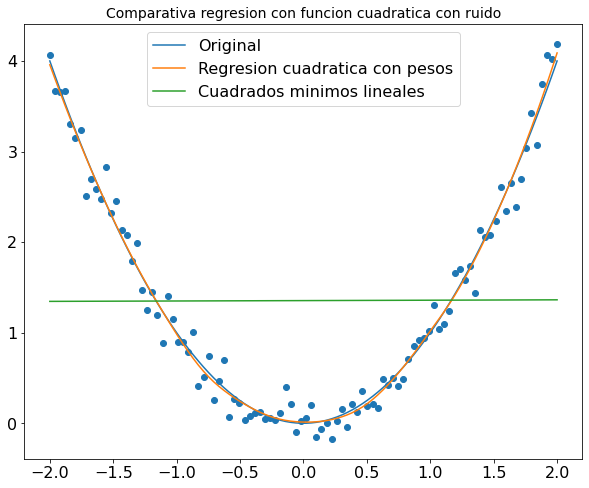

In [13]:
metrics = {}


fig = plt.figure(figsize=(10,8))
plt.scatter(X, y_s)
plt.plot(X, y_o, label="Original")
y_t = np.array([l.estimate(x, kernel="tricubic", window=int(n*0.5), degree=2) for x in X.reshape((100,1))])

y_t_2 = np.array([l.estimate(x, kernel="unweighted", window=n, degree=1) for x in X.reshape((100,1))])

plt.plot(X, y_t, label="Regresion cuadratica con pesos")
plt.plot(X, y_t_2, label="Cuadrados minimos lineales")

plt.title(f"Comparativa regresion con funcion cuadratica con ruido", fontsize=14)
plt.legend()
plt.savefig(f"img/exp3_cuadratic")

## Iris dataset

In [5]:
from sklearn import datasets
from sklearn.model_selection import train_test_split

In [6]:
iris = datasets.load_iris()
iris.target

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2])

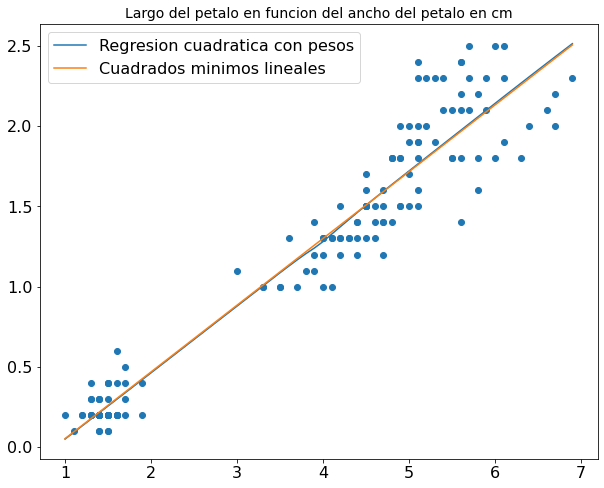

In [10]:
metrics = {}

data = np.sort(iris.data[:, 2])
y_train = iris.data[:, 3][np.argsort(iris.data[:, 2])]
l = Loess(data, y_train)

dist_funcs = ["tricubic", "unweighted"]

fig = plt.figure(figsize=(10,8))
plt.scatter(data, y_train)

rename = {
    "tricubic": "Regresion cuadratica con pesos",
    "unweighted": "Cuadrados minimos lineales",
}

for func in dist_funcs:
    if dist_funcs == "tricubic":
        y_t = np.array([l.estimate([x], kernel=func, window=int(len(data)*0.4), degree=2) for x in data])
    else:
        y_t = np.array([l.estimate([x], kernel=func, window=len(data), degree=1) for x in data])

    plt.plot(data, y_t, label=f"{rename[func]}")

    plt.title(f"Largo del petalo en funcion del ancho del petalo en cm", fontsize=14)
    plt.legend()
    plt.savefig(f"img/exp3_linear")

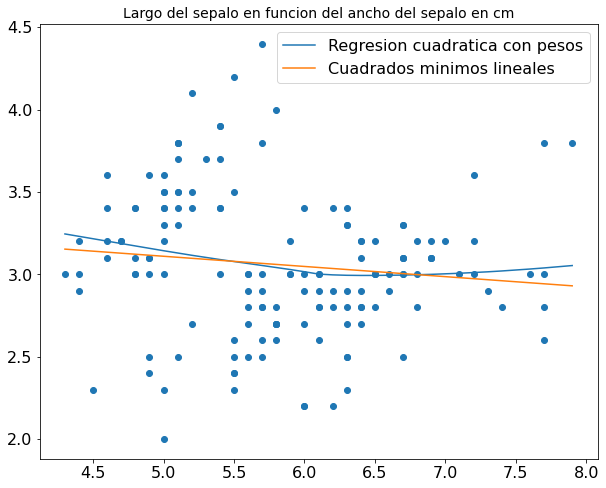

In [9]:
metrics = {}

data = np.sort(iris.data[:, 0])
y_train = iris.data[:, 1][np.argsort(iris.data[:, 0])]
l = Loess(data, y_train)

dist_funcs = ["tricubic", "unweighted"]

fig = plt.figure(figsize=(10,8))
plt.scatter(data, y_train)

rename = {
    "tricubic": "Regresion cuadratica con pesos",
    "unweighted": "Cuadrados minimos lineales",
}

for func in dist_funcs:
    if dist_funcs == "tricubic":
        y_t = np.array([l.estimate([x], kernel=func, window=int(len(data)*0.4), degree=2) for x in data])
    else:
        y_t = np.array([l.estimate([x], kernel=func, window=len(data), degree=1) for x in data])

    plt.plot(data, y_t, label=f"{rename[func]}")

    plt.title(f"Largo del sepalo en funcion del ancho del sepalo en cm", fontsize=14)
    plt.legend()
    plt.savefig(f"img/exp3_scattered")